In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'False'

In [2]:
import jax
jax.devices()

[CpuDevice(id=0)]

In [3]:
# again, this only works on startup!

import jax
jax.config.update("jax_enable_x64", True)

In [10]:
# create sampler and estimator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

backend_options = {
    "precision": "single",
    "max_parallel_threads": 12,
    "max_parallel_experiments": 0,
    "max_parallel_shots": 0,
    "fusion_enable": True,
    "fusion_threshold": 14,
    "fusion_max_qubit": 4,
    "matrix_product_state_max_bond_dimension": 16,
    "matrix_product_state_truncation_threshold": 1e-8,
    "mps_sample_measure_algorithm": "mps_apply_measure",
    "mps_parallel_threshold": 12,
    "mps_omp_threads": 12,
    "mps_lapack": False,
    "seed_simulator": 42,
}

aer_sim = AerSimulator(method="matrix_product_state", **backend_options)
aer_sim.set_max_qubits(200)

pm = generate_preset_pass_manager(
    backend=aer_sim, optimization_level=1, seed_transpiler=42
)

from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.primitives import SamplerV2 as Sampler

n_shots = 1000
sampler = Sampler(default_shots=n_shots, seed=42)
sampler._backend = aer_sim

estimator = Estimator()
estimator._backend = aer_sim

- magnetization operator: $\sum_i Z_i$
- mean spin correlation operator: $\sum_i Z_i Z_{i+1} / (n - 1)$.

In [11]:
from qiskit.quantum_info import SparsePauliOp

def tfim(n, J, h):
    ZZ_tuples = [("ZZ", [i, i + 1], J) for i in range(n - 1)]
    X_tuples = [("X", [i], h) for i in range(n)]

    H = SparsePauliOp.from_sparse_list([*ZZ_tuples, *X_tuples], num_qubits=n)
    return H


def aux_ham(n):
    # magnetization operator
    M = SparsePauliOp.from_sparse_list(
        [("Z", [i], 1.0) for i in range(0, n)], num_qubits=n
    )

    # mean spin correlation operator
    S = SparsePauliOp.from_sparse_list(
        [("ZZ", [i, i + 1], 1.0) for i in range(0, n - 1)], num_qubits=n
    ) / (n - 1)

    return M, S

## Exact

In [12]:
import scipy as sc
from qiskit.quantum_info import Statevector
from time import time

def exact_evolve(n, H, aux_obs=None, verbose=False):
    start = time()
    initial_state = Statevector.from_label("0" * n)

    # We compute the exact evolution using the exp
    # find faster way to do this classically
    H_array = H.to_matrix()
    exact_evolution = [
        initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in times
    ]

    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])

    if aux_obs is None:
        return exact_energy

    evs = []
    for ham in aux_obs:
        evs.append(
            np.real([sv.expectation_value(ham) for sv in exact_evolution])
        )
    evs = np.array(evs)
    end = time()
    if verbose:
        print(f"Duration for exact evolution: {end-start:.4f}")
        
    return np.vstack((exact_energy, evs))

## Trotter

In [13]:
def estimate_observables(ansatz, obs):
    pubs = [(ansatz, ham) for ham in obs]
    result = estimator.run(pubs).result()
    return np.array([res.data.evs for res in result])

In [14]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

def trotter_evolve(n, H, delta_t, n_steps, aux_obs=None, verbose=False):
    start = time()
    observables = []

    # append initial state if different that |00....0>
    qc = QuantumCircuit(n)
    for i in range(n_steps):
        if verbose:
            print(f"Time step: {i}")
    
        qc.append(PauliEvolutionGate(H, delta_t, synthesis=LieTrotter(reps=1)), range(n))
    
        # estimate observables
        isa_qc = pm.run(qc)
        observables.append(estimate_observables(isa_qc, [H] + aux_obs))

    observables = np.array(observables)
    end = time()
    if verbose:
        print(f"Duration for Trotter evolution: {end-start:.4f}")
    return observables

## SQTE

In [15]:
import jax


@jax.jit
def connected_elements_and_amplitudes_bool(bitstring, diag, sign, imag):
    """Find the connected element to computational basis state |X>."""
    bitstring_mask = bitstring == diag
    return bitstring_mask.astype(int), jnp.prod(
        (-1) ** (jnp.logical_and(bitstring, sign))
        * jnp.array(1j, dtype="complex64") ** (imag)
    )


batch_conn = jax.vmap(connected_elements_and_amplitudes_bool, (0, None, None, None))

In [16]:
def int_conversion_from_bts_array(bit_array: np.ndarray):
    """Convert a bit array to an integer representation."""
    n_qubits = len(bit_array)
    bitarray_asint = 0.0
    for i in range(n_qubits):
        bitarray_asint = bitarray_asint + bit_array[i] * 2 ** (n_qubits - 1 - i)

    return bitarray_asint.astype("longlong")  # type: ignore


bin_to_int = jax.jit(jax.vmap(int_conversion_from_bts_array, 0, 0))

In [17]:
from scipy.sparse import coo_matrix


def project_hamiltonian(samples, hamiltonian):
    d, n = samples.shape
    operator = coo_matrix((d, d), dtype="complex128")

    for i, pauli in enumerate(hamiltonian.paulis):
        coeff = hamiltonian.coeffs[i]
        row_ids = np.arange(d)

        # qubit wise representation
        diag = np.logical_not(pauli.x)[::-1]
        sign = pauli.z[::-1]
        imag = np.logical_and(pauli.x, pauli.z)[::-1]

        # convert to int
        decimal_values = bin_to_int(samples)

        samples_conn, amplitudes = batch_conn(samples, diag, sign, imag)

        decimal_conn = bin_to_int(samples_conn)

        conn_mask = np.isin(
            decimal_conn, decimal_values, assume_unique=True, kind="sort"
        )

        # keep samples that are represented both in the original samples
        # and connected elements
        amplitudes = amplitudes[conn_mask]
        decimal_conn = decimal_conn[conn_mask]
        row_ids = row_ids[conn_mask]

        # Get column indices of non-zero matrix elements
        col_ids = np.searchsorted(decimal_values, decimal_conn)

        operator += coeff * coo_matrix((amplitudes, (row_ids, col_ids)), (d, d))

    return operator

In [18]:
import jax.numpy as jnp

to_int_list = lambda bs: list(map(int, list(bs)))

def sampled_projector(ansatz, obs, seed=42):
    pubs = (ansatz,)
    sampler._seed = seed
    job = sampler.run(pubs)
    samples = job.result()[0].data.meas.get_bitstrings()
    samples = jnp.array([to_int_list(i) for i in samples])

    # add the basis states needed to express the initial state
    samples = jnp.r_[samples, [jnp.zeros(n, dtype=int)]]

    # Need to sort the binary rows and remove duplicates
    # for large integers, maybe try numpy lexsort
    decimal_values = bin_to_int(samples)

    _, indices = jnp.unique(decimal_values, return_index=True)
    samples = samples[indices]

    obs_proj = [project_hamiltonian(samples, ham) for ham in obs]
    return obs_proj, samples

In [19]:
def sampled_evolve(n, H, delta_t, n_steps, aux_obs=None, verbose=False):
    start = time()
    observables_sqte = []

    # append initial state if different that |00....0>
    qc = QuantumCircuit(n)
    for i in range(n_steps):
        if verbose:
            print(f"Time step: {i}")
    
        qc.append(PauliEvolutionGate(H, delta_t, synthesis=LieTrotter(reps=1)), range(n))
    
        # perform sampling and project observables
        isa_qc = pm.run(qc)
        isa_qc.measure_all()
        obs_proj, samples = sampled_projector(isa_qc, [H] + aux_obs)

        # project initial state
        # currently hardcoded and only works with |00 .. 0>
        psi0_proj = jnp.zeros(samples.shape[0])
        psi0_proj = psi0_proj.at[0].set(1.0)

        # normalize if needed
        norm = jnp.linalg.norm(psi0_proj)
        if not jnp.allclose(norm, 1.0):
            psi0_proj /= jnp.linalg.norm(psi0_proj)
    
        # Time evolution in projected space
        H_proj = obs_proj[0]
    
        U_proj = jax.scipy.linalg.expm(-1j * times[i] * H_proj.todense())
        psi_proj = U_proj @ psi0_proj
    
        # estimate observables classically
        evs = []
        for ham in obs_proj:
            evs.append(jnp.vdot(psi_proj, ham @ psi_proj))
    
        evs = jnp.real(jnp.array(evs))
        observables_sqte.append(evs)

    end = time()
    if verbose:
        print(f"Duration for sampled evolution: {end-start:.4f}")
        
    return jnp.array(observables_sqte)

## Time evolution Expt

In [20]:
import numpy as np

## configuration

# hamiltonian 
n = 12
J = 4.0
h = 2.0

# time evolution
final_time = 10.0
num_timesteps = 20
dt = final_time / num_timesteps
times = np.linspace(dt, final_time, num_timesteps)  # dosent include initial state

In [21]:
H = tfim(n, J, h)
M, S = aux_ham(n)

if n <= 10:
    exact_energy, exact_magnetization, exact_correlation = exact_evolve(n, H, [M, S], 1)

In [ ]:
observables = trotter_evolve(n, H, dt, num_timesteps, [M, S], 1)

Time step: 0
Time step: 1
Time step: 2
Time step: 3
Time step: 4
Time step: 5
Time step: 6


In [ ]:
observables_sqte = sampled_evolve(n, H, dt, num_timesteps, [M, S], 1)

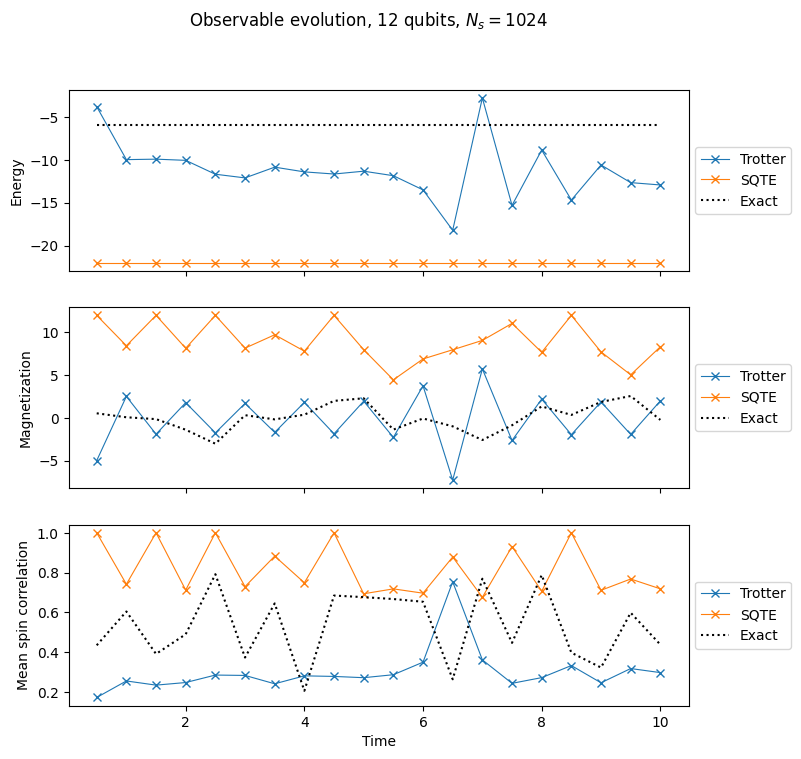

In [205]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True, figsize=(8, 8))
axes[0].plot(times, observables[:, 0], label="Trotter", marker="x", ls="-", lw=0.8)
axes[0].plot(times, observables_sqte[:, 0], label="SQTE", marker="x", ls="-", lw=0.8)


axes[1].plot(times, observables[:, 1], label="Trotter", marker="x", ls="-", lw=0.8)
axes[1].plot(times, observables_sqte[:, 1], label="SQTE", marker="x", ls="-", lw=0.8)

axes[2].plot(times, observables[:, 2], label="Trotter", marker="x", ls="-", lw=0.8)
axes[2].plot(times, observables_sqte[:, 2], label="SQTE", marker="x", ls="-", lw=0.8)

if n <=10:
    try:
        axes[0].plot(times, exact_energy, c="k", ls=":", label="Exact")
        axes[1].plot(times, exact_magnetization, c="k", ls=":", label="Exact")
        axes[2].plot(times, exact_correlation, c="k", ls=":", label="Exact")
    except:
        pass

for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


axes[0].set_ylabel("Energy")
axes[1].set_ylabel("Magnetization")
axes[2].set_ylabel("Mean spin correlation")
axes[2].set_xlabel("Time")


fig.suptitle(f"Observable evolution, {n} qubits, $ N_s = {n_shots}$")
plt.show()

## Fidelity

In [206]:
# n_qubits = [2, 4]

# for n in n_qubits:
#     print(n)
#     H = tfim(n, J, h)
#     M, S = aux_ham(n)

#     exact_energy, exact_magnetization, exact_correlation = exact_evolve(n, H, M, S)

#     observables_sqte = []
#     # append initial state if different that |00....0>
#     qc = QuantumCircuit(n)
#     for i in range(num_timesteps):    
#         qc.append(PauliEvolutionGate(H, dt, synthesis=LieTrotter(reps=1)), range(n))
    
#         # perform sampling and project observables
#         isa_qc = pm.run(qc)
#         isa_qc.measure_all()
#         obs_proj, samples = sqte(isa_qc, [H, M, S])
    
#         # project initial state
#         # currently hardcoded and only works with |00 .. 0>
#         psi0_proj = jnp.zeros(samples.shape[0])
#         psi0_proj = psi0_proj.at[0].set(1.0)
    
#         # normalize if needed
#         norm = jnp.linalg.norm(psi0_proj)
#         if not jnp.allclose(norm, 1.0):
#             psi0_proj /= jnp.linalg.norm(psi0_proj)
    
#         # Time evolution in projected space
#         H_proj = obs_proj[0]
    
#         start = time()
#         U_proj = jax.scipy.linalg.expm(-1j * times[i] * H_proj.todense())
#         psi_proj = U_proj @ psi0_proj
    
#         # estimate observables classically
#         evs = []
#         for ham in obs_proj:
#             evs.append(jnp.vdot(psi_proj, ham @ psi_proj))
    
#         evs = jnp.real(jnp.array(evs))
#         observables_sqte.append(evs)
    
#     observables_sqte = jnp.array(observables_sqte)
        